#San Francisco Building Complaints Analysis

# Data Source

San Francisco Government's Open Data: https://reurl.cc/eGKE5K

#Load Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("C:\Boston University_資料夾\BA820_unsupervised machine learning\project\Department_of_Building_Inspection_Complaints__All_Divisions.csv")

In [ ]:
df.describe()

,Street Number,ZIP Code,Supervisor District
count,310076.000000,309933.000000,309546.000000
mean,1198.582122,94115.473493,5.786946
std,1162.789639,9.120995,3.076982
min,0.000000,94102.000000,1.000000
25%,320.000000,94109.000000,3.000000
50%,832.000000,94114.000000,5.000000
75%,1719.000000,94122.000000,9.000000
max,9490.000000,94158.000000,11.000000


# EDA

## Correlation Between Features

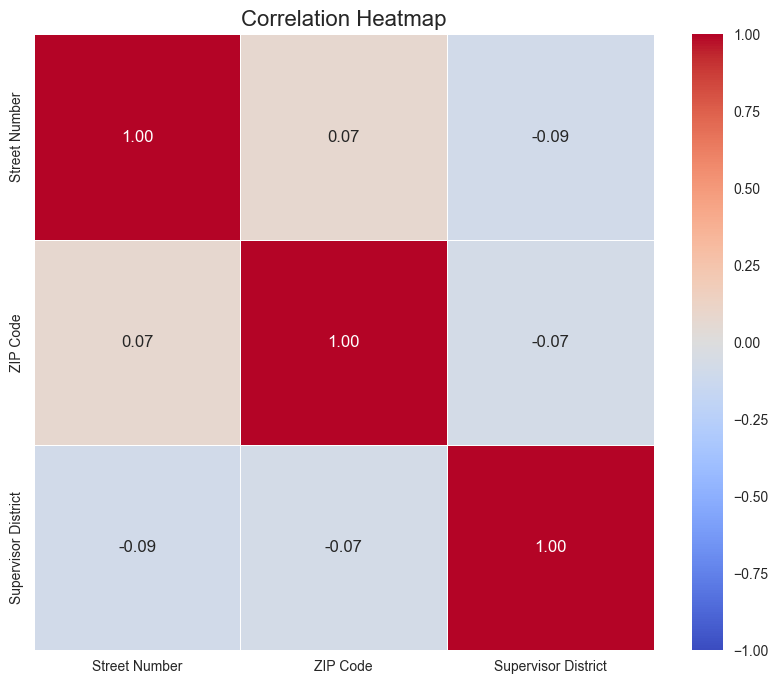

In [ ]:
numeric_columns = df.select_dtypes(include=['number'])


# Calculate the correlation matrix for the remaining numeric columns
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks()
plt.yticks()
plt.show()

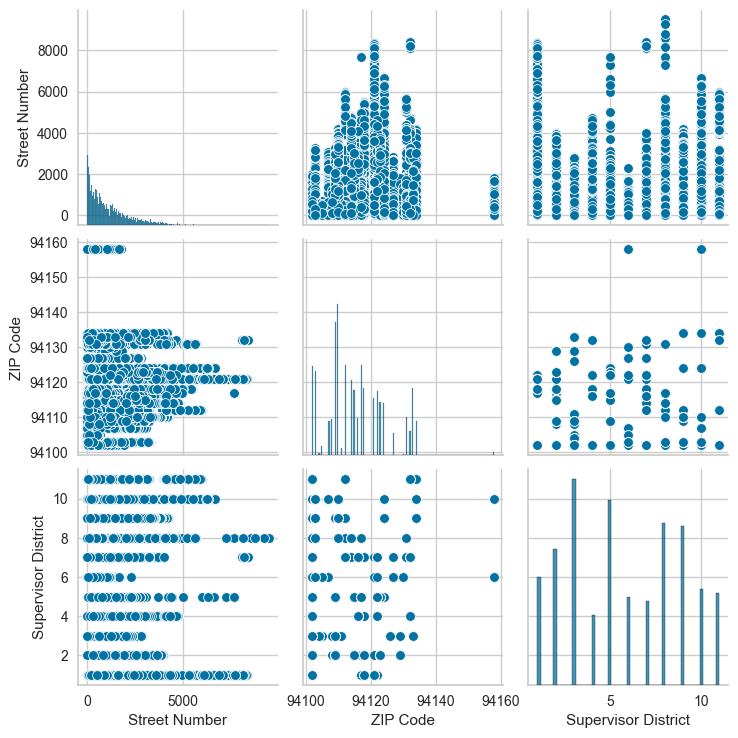

In [ ]:
sns.pairplot(df)

## Top 10 Neighborhoods

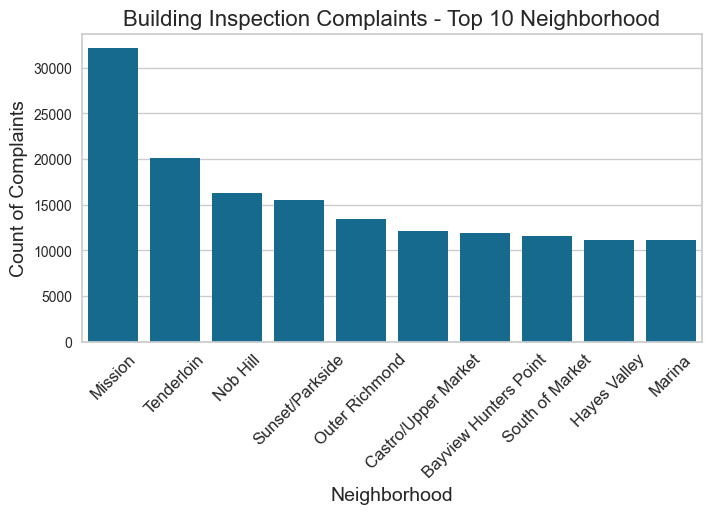

In [ ]:
neighborhood_complaints = df['Analysis Neighborhood'].value_counts().sort_values(ascending=False)
top_10_neighborhoods = neighborhood_complaints.head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x=top_10_neighborhoods.index, y=top_10_neighborhoods.values)

plt.xlabel('Neighborhood', fontsize =14)
plt.ylabel('Count of Complaints', fontsize =14)
plt.xticks(rotation=45, fontsize =12)
plt.title('Building Inspection Complaints - Top 10 Neighborhood', fontsize =16)

plt.show()

## Top Divisions

In [ ]:
receiving_counts = df['Receiving Division'].value_counts()
assigned_counts = df['Assigned Division'].value_counts()

divisions = pd.merge(receiving_counts, assigned_counts, left_index=True, right_index=True, suffixes=('_receiving', '_assigned'))
divisions.sort_values(by='count_receiving', ascending=False, inplace= True)
divisions.reset_index(inplace=True)
divisions.rename(columns={'index': 'division'}, inplace=True)

melt_divisions = divisions.melt(id_vars=['division'], var_name='Count Type', value_name='Count')

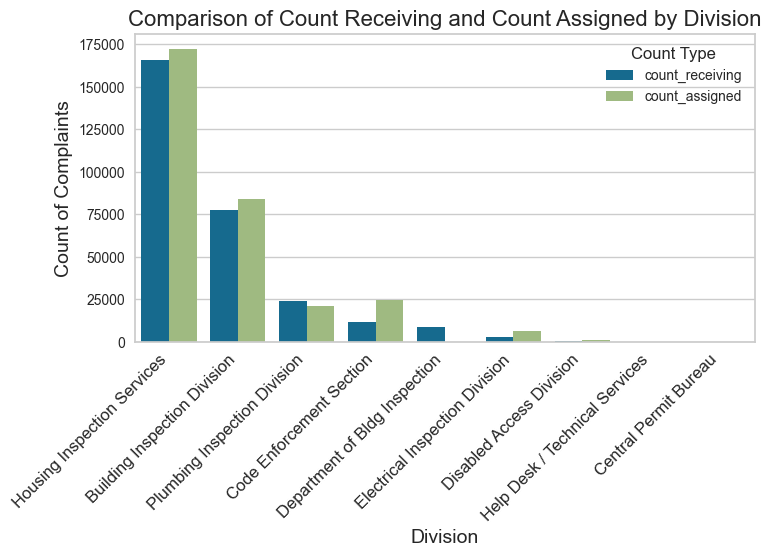

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='division', y='Count', hue='Count Type', data=melt_divisions)
plt.xlabel('Division', fontsize =14)
plt.ylabel('Count of Complaints', fontsize =14)
plt.title('Comparison of Count Receiving and Count Assigned by Division', fontsize =16)
plt.xticks(rotation= 45, ha='right', fontsize =12)
plt.legend(title='Count Type')

### Mismatch Rate

In [ ]:
division_list = melt_divisions['division'].iloc[0:9]
division_list = division_list.tolist()
division_list

['Housing Inspection Services',
 'Building Inspection Division',
 'Plumbing Inspection Division',
 'Code Enforcement Section',
 'Department of Bldg Inspection',
 'Electrical Inspection Division',
 'Disabled Access Division',
 'Help Desk / Technical Services',
 'Central Permit Bureau']

In [ ]:
df_for_analysis = df.copy()
df_for_analysis['mismatch'] = (
    df_for_analysis['Receiving Division'] != df_for_analysis['Assigned Division']
)

receiving_division_stats = (
    df_for_analysis.groupby('Receiving Division')
    .agg(total_count=('Receiving Division', 'count'),
         mismatch_rate=('mismatch', 'mean'))
    .reset_index()
)

receiving_division_filtered = receiving_division_stats[receiving_division_stats['Receiving Division'].isin(division_list)]

df_for_analysis['mismatch'].mean()

0.1777048207536217

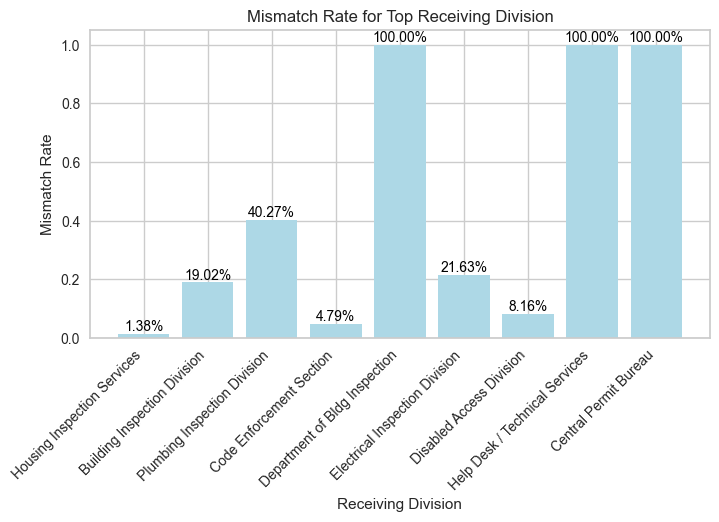

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

receiving_division_filtered['Receiving Division'] = pd.Categorical(
    receiving_division_filtered['Receiving Division'],
    categories=division_list,
    ordered=True)

receiving_division_filtered.sort_values('Receiving Division', inplace=True)

top10_df = receiving_division_filtered.head(10)

plt.figure(figsize=(8, 4))
bars = plt.bar(top10_df['Receiving Division'], top10_df['mismatch_rate'], color='lightblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2%}',
             ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Receiving Division')
plt.ylabel('Mismatch Rate')
plt.title('Mismatch Rate for Top Receiving Division')
plt.xticks(rotation=45, ha='right')
plt.show()


# Data Preprocessing

In [ ]:
df.isnull().sum()

Complaint Number              0
Date Filed                    5
Closed Date              219138
Block                         0
Lot                           0
Parcel Number                 0
Street Number                 0
Street Name                   0
Street Suffix                 0
ZIP Code                    143
Complaint Description       434
Status                        0
Receiving Division            0
Assigned Division             8
Analysis Neighborhood       530
Supervisor District         530
point                       530
point_source                530
data_as_of                    0
data_loaded_at                0
Season                        0
dtype: int64

In [ ]:

df.duplicated().sum()


0

In [ ]:
df_clean = df

df_clean['Closed Date'] = df_clean['Closed Date'].fillna('1900-01-01')

In [ ]:
df_clean['Complaint Description'] = df_clean['Complaint Description'].fillna('No Description')
df_clean = df_clean.dropna(subset = ['ZIP Code', 'Analysis Neighborhood', 'Supervisor District', 'point', 'point_source'])


In [ ]:
df_clean.isnull().sum()

Complaint Number         0
Date Filed               5
Closed Date              0
Block                    0
Lot                      0
Parcel Number            0
Street Number            0
Street Name              0
Street Suffix            0
ZIP Code                 0
Complaint Description    0
Status                   0
Receiving Division       0
Assigned Division        8
Analysis Neighborhood    0
Supervisor District      0
point                    0
point_source             0
data_as_of               0
data_loaded_at           0
Season                   0
dtype: int64

In [ ]:
df_clean['Date Filed'] = pd.to_datetime(df_clean['Date Filed'],  errors='coerce')
df_clean['Closed Date'] = pd.to_datetime(df_clean['Closed Date'],  errors='coerce', dayfirst=False)

df_clean['Filed_year'] = df_clean['Date Filed'].dt.year
df_clean['Filed_month'] = df_clean['Date Filed'].dt.month
df_clean['Filed_day'] = df_clean['Date Filed'].dt.day
df_clean['Closed_year'] = df_clean['Closed Date'].dt.year
df_clean['Closed_month'] = df_clean['Closed Date'].dt.month
df_clean['Closed_day'] = df_clean['Closed Date'].dt.day




df_clean = df_clean.drop(columns=[
                            'Date Filed', 'Closed Date',
                            'Block', 'Lot','Parcel Number', 'Street Number', 'Street Name', 'Street Suffix', 'point', 'point_source',
                            'data_as_of', 'data_loaded_at'])
df_LDA = df_clean
df_clean = df_clean.drop(columns = ['Complaint Number'])

df_clean_raw = df_clean.drop(columns=['Closed_year', 'Closed_month', 'Closed_day', 'Complaint Description'])
df_clean_raw.head()


,ZIP Code,Status,Receiving Division,Assigned Division,Analysis Neighborhood,Supervisor District,Season,Filed_year,Filed_month,Filed_day
30,94124.0,Active,Code Enforcement Section,Code Enforcement Section,Bayview Hunters Point,10.0,Winter,2024.0,2.0,7.0
32,94114.0,Active,Code Enforcement Section,Code Enforcement Section,Noe Valley,8.0,Fall,2023.0,11.0,1.0
36,94102.0,Active,Housing Inspection Services,Housing Inspection Services,Tenderloin,5.0,Fall,2024.0,11.0,21.0
37,94102.0,Not Active,Housing Inspection Services,Housing Inspection Services,Tenderloin,5.0,Summer,1994.0,7.0,27.0
38,94112.0,Not Active,Housing Inspection Services,Housing Inspection Services,Outer Mission,11.0,Summer,1995.0,7.0,31.0


In [ ]:
df_clean_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309423 entries, 30 to 310075
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ZIP Code               309423 non-null  float64
 1   Status                 309423 non-null  object 
 2   Receiving Division     309423 non-null  object 
 3   Assigned Division      309415 non-null  object 
 4   Analysis Neighborhood  309423 non-null  object 
 5   Supervisor District    309423 non-null  float64
 6   Season                 309423 non-null  object 
 7   Filed_year             309418 non-null  float64
 8   Filed_month            309418 non-null  float64
 9   Filed_day              309418 non-null  float64
dtypes: float64(5), object(5)
memory usage: 26.0+ MB


In [ ]:
df_clean_raw.isnull().sum()

ZIP Code                 0
Status                   0
Receiving Division       0
Assigned Division        8
Analysis Neighborhood    0
Supervisor District      0
Season                   0
Filed_year               5
Filed_month              5
Filed_day                5
dtype: int64

In [ ]:
df_clean_raw = df_clean_raw.dropna()
df_LDA = df_LDA.dropna()

In [ ]:
df_kmeans_review = df_clean_raw


In [ ]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['Status', 'Receiving Division', 'Assigned Division', 'Analysis Neighborhood', 'Season']

encoders = {}

for col in categorical_columns:
    encoder = LabelEncoder()
    df_clean_raw[col] = encoder.fit_transform(df_clean_raw[col])
    encoders[col] = encoder




In [ ]:
df_clean_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309410 entries, 30 to 310075
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ZIP Code               309410 non-null  float64
 1   Status                 309410 non-null  int32  
 2   Receiving Division     309410 non-null  int32  
 3   Assigned Division      309410 non-null  int32  
 4   Analysis Neighborhood  309410 non-null  int32  
 5   Supervisor District    309410 non-null  float64
 6   Season                 309410 non-null  int32  
 7   Filed_year             309410 non-null  float64
 8   Filed_month            309410 non-null  float64
 9   Filed_day              309410 non-null  float64
dtypes: float64(5), int32(5)
memory usage: 20.1 MB


# Prelimanary Results and Analysis

In [ ]:
df_clean_raw.isnull().sum()

ZIP Code                 0
Status                   0
Receiving Division       0
Assigned Division        0
Analysis Neighborhood    0
Supervisor District      0
Season                   0
Filed_year               0
Filed_month              0
Filed_day                0
dtype: int64

## K-Means Clustering

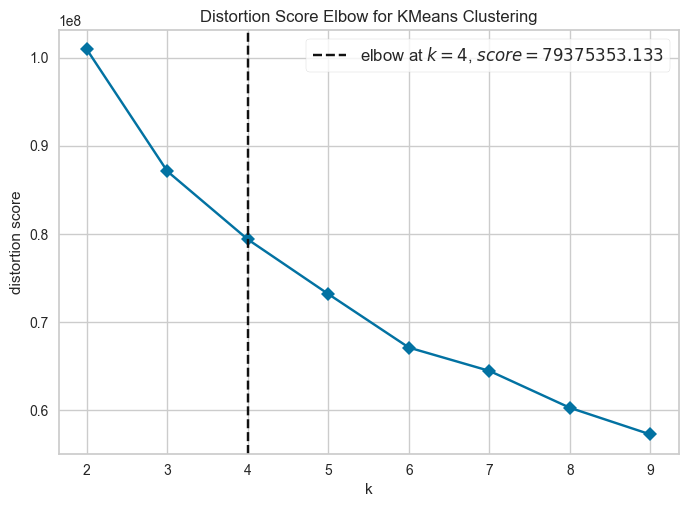

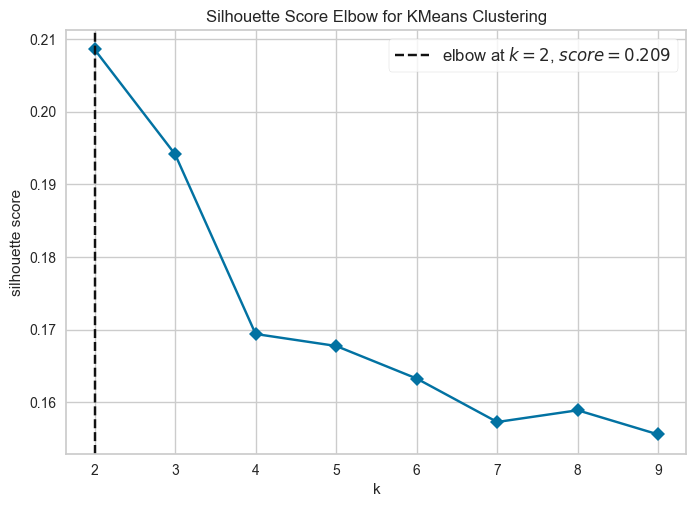

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(2, random_state= 42)

kmeans.fit(df_clean_raw)


visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='distortion', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(df_clean_raw)        # Fit the data to the visualizer
visualizer.show()

visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='silhouette', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(df_clean_raw)        # Fit the data to the visualizer
visualizer.show()


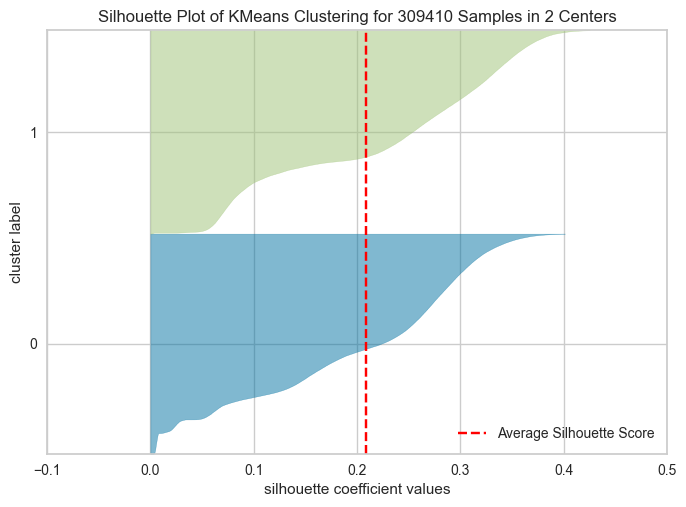

Silhouette Score: 0.209


In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

kmeans_model = KMeans(2, random_state= 42)
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick', timings=False)

visualizer.fit(df_clean_raw)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
labels = kmeans_model.labels_
score = silhouette_score(df_clean_raw, labels)
print("Silhouette Score: {:.3f}".format(score))

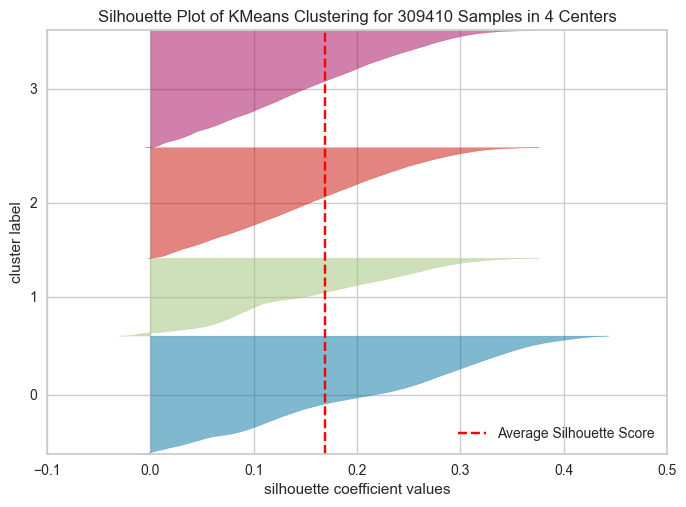

Silhouette Score: 0.169


In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

kmeans_model_4 = KMeans(4, random_state= 42)
visualizer = SilhouetteVisualizer(kmeans_model_4, colors='yellowbrick', timings=False)

visualizer.fit(df_clean_raw)        # Fit the data to the visualizer
visualizer.show()
labels = kmeans_model_4.labels_
score = silhouette_score(df_clean_raw, labels)
print("Silhouette Score: {:.3f}".format(score))

## Hierarchical Clustering

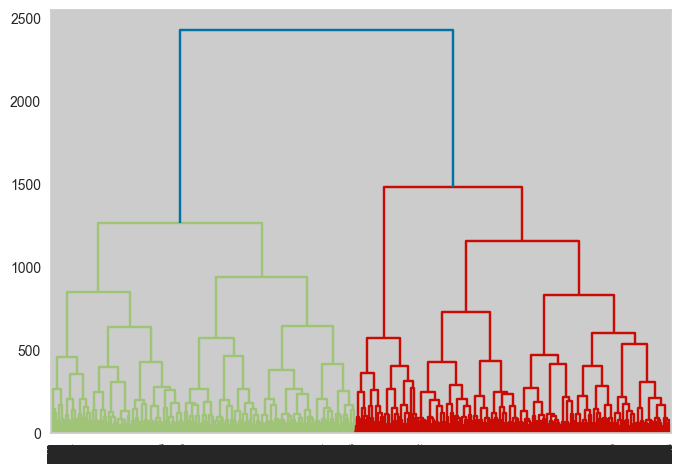

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils import resample

sampling_fraction = 0.1


min_samples = 200
sample_size = max(int(len(df_clean_raw) * sampling_fraction), min_samples)


df_sampled = resample(df_clean_raw, n_samples=sample_size, random_state=42, replace=False)
Z = linkage(df_sampled, 'ward')
_ = dendrogram(Z)

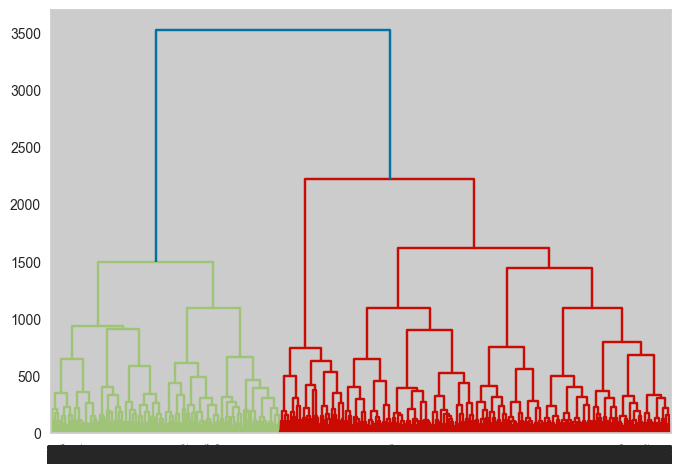

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils import resample

sampling_fraction = 0.2


min_samples = 200
sample_size = max(int(len(df_clean_raw) * sampling_fraction), min_samples)


df_sampled = resample(df_clean_raw, n_samples=sample_size, random_state=42, replace=False)
Z = linkage(df_sampled, 'ward')
_ = dendrogram(Z)

In [ ]:
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
linkage_methods = ['ward', 'single', 'complete', 'average']

scores = {}

for method in linkage_methods:
    # Compute linkage matrix
    linkage_matrix = sch.linkage(df_sampled, method=method)


    # Apply clustering (Assume 3 clusters for evaluation)
    labels = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')

    # Compute silhouette score
    silhouette_avg = silhouette_score(df_sampled, labels)
    scores[method] = silhouette_avg



# Convert scores to DataFrame for visualization
scores_df = pd.DataFrame(scores.items(), columns=['Method', 'Silhouette Score'])

# Display results
print(scores_df)

     Method  Silhouette Score
0      ward          0.215499
1    single          0.413608
2  complete          0.413608
3   average          0.413608


# Advanced Analysis

## Text Mining

In [ ]:
df_text = df_clean[['Complaint Description']]
df_text.rename(columns={'Complaint Description': 'text'}, inplace=True)
df_text

,text
30,Vacant building
32,Vacant storefront
36,No heat
37,No cold water(unable to shower) no heat...poss...
38,Illegal unit-no separate meter; meter is share...
...,...
310071,Date last observed: 03-sep-24; exact location:...
310072,Unpermitted construction in unit 2. they have ...
310073,Date last observed: 24-oct-24; identity of per...
310074,No heat 9am-5pm daily.


In [ ]:
df_text = pd.DataFrame(df_text.text.str.lower())

### Text Preprocessing & Tokenization

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Rick/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Rick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
text_list = df_text['text'].tolist()
text_list = [t for t in text_list if t.strip()]

df_text['tokens'] = df_text['text'].apply(word_tokenize)
df_text

,text,tokens
30,vacant building,"[vacant, building]"
32,vacant storefront,"[vacant, storefront]"
36,no heat,"[no, heat]"
37,no cold water(unable to shower) no heat...poss...,"[no, cold, water, (, unable, to, shower, ), no..."
38,illegal unit-no separate meter; meter is share...,"[illegal, unit-no, separate, meter, ;, meter, ..."
...,...,...
310071,date last observed: 03-sep-24; exact location:...,"[date, last, observed, :, 03-sep-24, ;, exact,..."
310072,unpermitted construction in unit 2. they have ...,"[unpermitted, construction, in, unit, 2., they..."
310073,date last observed: 24-oct-24; identity of per...,"[date, last, observed, :, 24-oct-24, ;, identi..."
310074,no heat 9am-5pm daily.,"[no, heat, 9am-5pm, daily, .]"


In [ ]:
from nltk.stem import WordNetLemmatizer
import string
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def cleanup_text_lem(sentence):
    # Tokenize
    tokenized_sms_messages = word_tokenize(sentence)

    # Lowercase
    tokenized_sms_messages = [word.lower() for word in tokenized_sms_messages]

    # Remove punctuation
    tokenized_sms_messages = [word for word in tokenized_sms_messages if word not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokenized_sms_messages = [word for word in tokenized_sms_messages if word not in stop_words]

    # Lemmatize
    tokenized_sms_messages = [lemmatizer.lemmatize(word) for word in tokenized_sms_messages]

    return tokenized_sms_messages

[nltk_data] Downloading package wordnet to C:\Users\Rick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Rick/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
tokenized_complaint_lem= df_text["text"].apply(cleanup_text_lem)
tokenized_complaint_lem

30                                       [vacant, building]
32                                     [vacant, storefront]
36                                                   [heat]
37        [cold, water, unable, shower, heat, ..., possi...
38        [illegal, unit-no, separate, meter, meter, sha...
                                ...                        
310071    [date, last, observed, 03-sep-24, exact, locat...
310072    [unpermitted, construction, unit, 2., complete...
310073    [date, last, observed, 24-oct-24, identity, pe...
310074                               [heat, 9am-5pm, daily]
310075    [internal, audit, reason, believe, work, compl...
Name: text, Length: 309423, dtype: object

In [ ]:
df_lem = pd.DataFrame(tokenized_complaint_lem)
df_lem

,text
30,"[vacant, building]"
32,"[vacant, storefront]"
36,[heat]
37,"[cold, water, unable, shower, heat, ..., possi..."
38,"[illegal, unit-no, separate, meter, meter, sha..."
...,...
310071,"[date, last, observed, 03-sep-24, exact, locat..."
310072,"[unpermitted, construction, unit, 2., complete..."
310073,"[date, last, observed, 24-oct-24, identity, pe..."
310074,"[heat, 9am-5pm, daily]"


### Vectorization - TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_lem['lem_text_str'] = df_lem['text'].apply(lambda tokens: ' '.join(tokens))


tfidf_model = TfidfVectorizer(norm=None)

tfidf_model.fit(df_lem['lem_text_str'])

df_tfidf_transformed = tfidf_model.transform(df_lem['lem_text_str'])
tfidf_vectors = pd.DataFrame.sparse.from_spmatrix(df_tfidf_transformed, columns=tfidf_model.get_feature_names_out())
tfidf_vectors

,00,000,0000,000000000000000,000000000000000000000000000000000000000000000000000000,000006,000008,0000172490,000017var,000145,...,zuni,zuniga,zurich,zusin,zuyn04a5ap4bnt_9k5be,zxy9zw1hawwmbd0xodczmtcmcd1saxn0aw5nx3vwzgf0zxnfaw5zdgfudf8xnsz0cz0xnti4mtm3njyymjexjme9y2xpy2smcz1myxzvcml0zxmmdd1pbwfnzszlbwfpbf9pzd0xodczmtdfmtuyodeznzy1ov8yjnvwzgf0zv90exblptmmbglzdgluz19pzd04mtmzotk4mszwcm9wzxj0ev9pzd0yodq3otyxoszwb3npdglvbl9udw1izxi9ma,zxy9zw1hawwmbd0xodczmtcmcd1saxn0aw5nx3vwzgf0zxnfaw5zdgfudf8xnsz0cz0xntq0nzqxmzg3nza5jme9y2xpy2smcz1myxzvcml0zxmmdd1pbwfnzszlbwfpbf9pzd0xodczmtdfmtu0ndc0mtm4nf8yjnvwzgf0zv90exblptqmbglzdgluz19pzd05nzi1mdixnczwcm9wzxj0ev9pzd03mtmymdmmcg9zaxrpb25fbnvtymvypta,zynga,zyphers,zz21
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler
df_tfidf = pd.DataFrame(tfidf_vectors)
sc = StandardScaler(with_mean=False)
normalized_data = sc.fit_transform(df_tfidf)

In [ ]:
normalized_data.shape

(309423, 94068)

### Vectorization - Bag of Word

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
df_bow = df_lem
df_bow['text'] = df_lem['text'].astype(str)
list_lem = df_bow['text'].tolist()
cv = CountVectorizer(max_features=10000)
cv.fit(list_lem)
print('number of `tokens`', len(cv.vocabulary_))
cv.vocabulary_

number of `tokens` 10000


{'vacant': 9555,
 'building': 2567,
 'storefront': 8750,
 'heat': 5043,
 'cold': 3001,
 'water': 9760,
 'unable': 9354,
 'shower': 8342,
 'possible': 7180,
 'radiant': 7437,
 'heating': 5049,
 'system': 8961,
 'illegal': 5244,
 'unit': 9419,
 'no': 6532,
 'separate': 8178,
 'meter': 6234,
 'shared': 8274,
 'owner': 6810,
 'type': 9340,
 'liquid': 5914,
 'dripping': 3913,
 'ceiling': 2780,
 'foul': 4598,
 'odor': 6654,
 'coming': 3039,
 'dropped': 3921,
 'leg': 5823,
 'sleeping': 8442,
 'caused': 2760,
 'diabetic': 3666,
 'chemical': 2843,
 'could': 3318,
 'dangerous': 3454,
 'damage': 3442,
 'rain': 7448,
 'leak': 5792,
 'window': 9861,
 'broken': 2519,
 'oven': 6769,
 'leaking': 5796,
 'gas': 4729,
 'front': 4654,
 'door': 3843,
 'secure': 8136,
 'adequate': 1745,
 'manager': 6087,
 'say': 8068,
 'access': 1679,
 'control': 3255,
 'temperature': 9027,
 'never': 6503,
 '65': 1308,
 'mr': 6405,
 '673': 1331,
 'garbage': 4720,
 'everywhere': 4219,
 'side': 8366,
 'accumulating': 1700,
 '

In [ ]:
dtm = cv.transform(list_lem)
bow = pd.DataFrame.sparse.from_spmatrix(dtm, columns=cv.get_feature_names_out())

### Topic Modeling - LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=10, random_state=42)

lda_model.fit(df_tfidf_transformed)

topic_word_distributions = lda_model.components_

document_topics = lda_model.transform(df_tfidf_transformed)
import numpy as np

n_top_words = 10
word_distributions = lda_model.components_
feature_names = tfidf_model.get_feature_names_out()
for topic_idx, topic in enumerate(word_distributions):
    top_features_indices = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_indices]
    print(f"Topic {topic_idx}: {top_features}")

Topic 0: ['last', 'observed', 'building', 'bldg', 'location', 'type', 'date', 'exact', 'main', 'additional']
Topic 1: ['permit', 'paint', 'without', 'work', 'out', 'peeling', 'construction', 'debris', 'see', 'lead']
Topic 2: ['construction', 'noise', '311', 'sr', 'loud', 'complaint', 'story', 'night', 'day', 'hour']
Topic 3: ['property', 'neighbor', 'permit', 'fence', 'backyard', 'line', 'unsafe', 'house', 'yard', 'without']
Topic 4: ['door', 'fire', 'area', 'window', 'common', 'front', 'stair', 'back', 'rear', 'building']
Topic 5: ['caller', 'mold', 'water', 'ceiling', 'damage', 'leaking', 'leak', 'customer', 'wall', 'state']
Topic 6: ['unit', 'illegal', 'garage', 'basement', 'room', 'possible', 'kitchen', 'living', 'permit', 'people']
Topic 7: ['heat', 'water', 'hot', 'electrical', 'heater', 'bathroom', 'kitchen', 'leak', 'landlord', 'sink']
Topic 8: ['work', 'last', 'observed', 'building', 'additional', 'time', 'residence', 'information', 'person', 'dwelling']
Topic 9: ['routine', '

In [ ]:
df_lem.shape

(309423, 2)

In [ ]:
topic_labels = {
    0: "Property Exterior & Neighborhood",     # property, attached, neighbor, sidewalk, etc.
    1: "Commercial/Health Violations",         # vacant, storefront, health, etc.
    2: "Interior Plumbing & Mold",             # bathroom, mold, leak, sink, etc.
    3: "Illegal Basement & Water Damage",       # basement, mold, leaking, illegal, etc.
    4: "Construction Noise & Complaints",       # construction, noise, complaint, etc.
    5: "Permits & Utility Installations",       # permit, boiler, electrical, plumbing, etc.
    6: "Inspection Records & Additional Info",  # observed, date, location, info, etc.
    7: "Illegal Garage/Deck Construction",      # garage, rear, deck, without permit, etc.
    8: "Routine Inspections & Common Areas",    # routine, inspection, common, area, hotel, etc.
    9: "Fire Safety & Broken Facilities"        # fire, elevator, garbage, broken, etc.
}
import numpy as np

df_lem['main_topic'] = np.argmax(document_topics, axis=1)

df_lem['topic_label'] = df_lem['main_topic'].map(topic_labels)
df_lem

,text,lem_text_str,main_topic,topic_label
30,"['vacant', 'building']",vacant building,0,Property Exterior & Neighborhood
32,"['vacant', 'storefront']",vacant storefront,0,Property Exterior & Neighborhood
36,['heat'],heat,7,Illegal Garage/Deck Construction
37,"['cold', 'water', 'unable', 'shower', 'heat', ...",cold water unable shower heat ... possible rad...,7,Illegal Garage/Deck Construction
38,"['illegal', 'unit-no', 'separate', 'meter', 'm...",illegal unit-no separate meter meter shared owner,6,Inspection Records & Additional Info
...,...,...,...,...
310071,"['date', 'last', 'observed', '03-sep-24', 'exa...",date last observed 03-sep-24 exact location ma...,0,Property Exterior & Neighborhood
310072,"['unpermitted', 'construction', 'unit', '2.', ...",unpermitted construction unit 2. completely gu...,1,Commercial/Health Violations
310073,"['date', 'last', 'observed', '24-oct-24', 'ide...",date last observed 24-oct-24 identity person p...,0,Property Exterior & Neighborhood
310074,"['heat', '9am-5pm', 'daily']",heat 9am-5pm daily,2,Interior Plumbing & Mold


In [ ]:
df_features_review = df_clean_raw
df_features_review['topic_label'] = df_lem['topic_label']
label_encoders = {}
label_encoder = LabelEncoder()
df_features_review['topic_label'] = label_encoder.fit_transform(df_features_review['topic_label'])
label_encoders['topic_label'] = label_encoder

## K-Means Clustering with Topic Labels

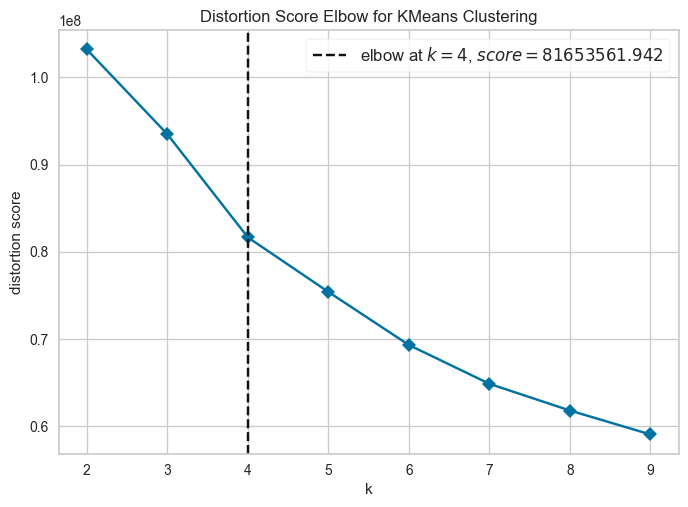

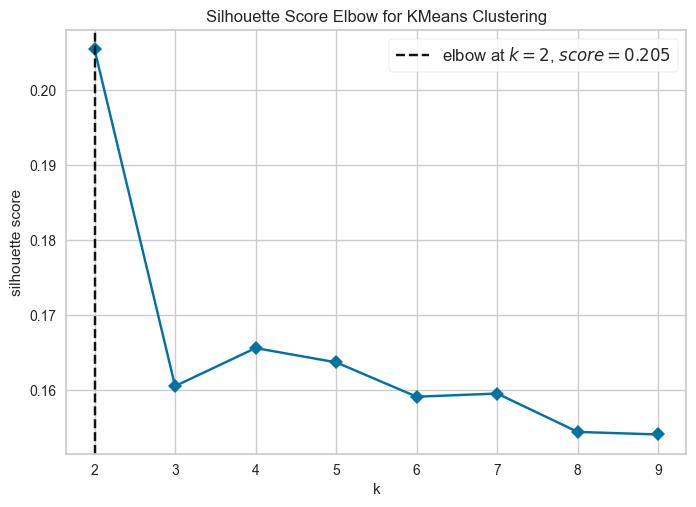

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(2, random_state= 42)

kmeans.fit(df_features_review)


visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='distortion', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(df_features_review)        # Fit the data to the visualizer
visualizer.show()

visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='silhouette', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(df_features_review)        # Fit the data to the visualizer
visualizer.show()

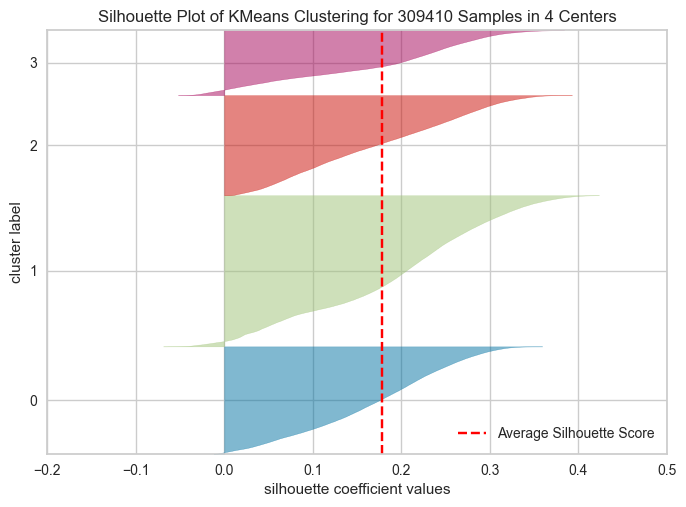

Silhouette Score: 0.178


In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

kmeans_withreview_model_4 = KMeans(4, random_state= 42)
visualizer = SilhouetteVisualizer(kmeans_withreview_model_4, colors='yellowbrick', timings=False)

visualizer.fit(df_features_review)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
labels = kmeans_withreview_model_4.labels_
score = silhouette_score(df_features_review, labels)
print("Silhouette Score: {:.3f}".format(score))

In [ ]:
df_kmeans_review_withtext = df_features_review
df_kmeans_review_withtext['distortion_Label'] = kmeans_withreview_model_4.labels_

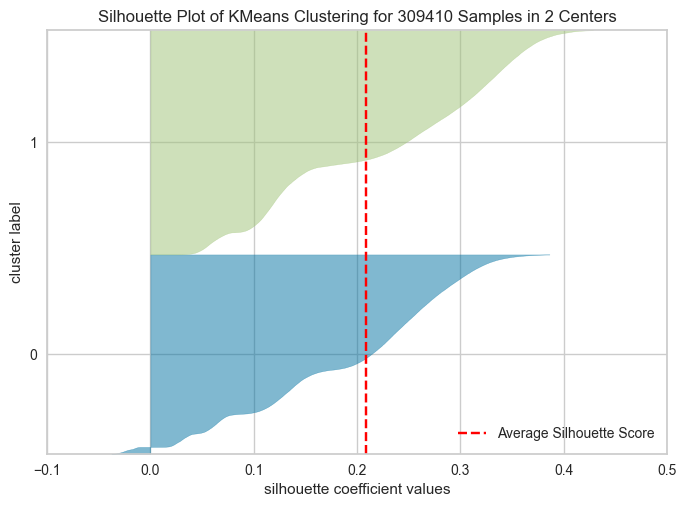

Silhouette Score: 0.208


In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

kmeans_withreview_model_2 = KMeans(2, random_state= 42)
visualizer = SilhouetteVisualizer(kmeans_withreview_model_2, colors='yellowbrick', timings=False)

visualizer.fit(df_features_review)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
labels = kmeans_withreview_model_2.labels_
score = silhouette_score(df_features_review, labels)
print("Silhouette Score: {:.3f}".format(score))

In [ ]:
df_kmeans_review_withtext['Silhouette_Label'] = kmeans_withreview_model_2.labels_

In [ ]:
df_kmeans_review_withtext['topic_label'] = label_encoders['topic_label'].inverse_transform(df_kmeans_review['topic_label'])
for col in categorical_columns:
    df_kmeans_review_withtext[col] = encoders[col].inverse_transform(df_clean_raw[col])

## Association Rules

### Division Mismatch Rates

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
df_labeled_division = df_kmeans_review_withtext.copy()
df_labeled_division["Receiving Division"] = (df_labeled_division["Receiving Division"].astype(str) + " (Receiving)")
df_labeled_division["Assigned Division"] = (df_labeled_division["Assigned Division"].astype(str) + " (Assigned)")

In [ ]:
df_division_status = df_labeled_division[['Receiving Division', 'Assigned Division']]
division_status_list = df_division_status.apply(lambda x: set(x.astype(str)), axis=1).tolist()
te = TransactionEncoder()
transactions = te.fit(division_status_list).transform(division_status_list)
division_encoded = pd.DataFrame(transactions, columns=te.columns_)
frequent_itemsets_division = apriori(division_encoded, min_support=0.01, use_colnames=True)
division_rules = association_rules(frequent_itemsets_division, frequent_itemsets_division.shape[0], metric="lift", min_threshold=1.0)

In [ ]:
division_rules['antecedents_stripped'] = (
    division_rules['antecedents'].astype(str)
    .str.replace(r'\(Assigned\)|\(Receiving\)', '', regex=True)
    .str.strip())
division_rules['consequents_stripped'] = (
    division_rules['consequents'].astype(str)
    .str.replace(r'\(Assigned\)|\(Receiving\)', '', regex=True)
    .str.strip())
antecedents_not_consequents = division_rules[
    division_rules['antecedents_stripped'] != division_rules['consequents_stripped']]

In [ ]:
eda_divisions = (
    "Building Inspection Division|"
    "Plumbing Inspection Division|"
    "Department of Bldg Inspection|"
    "Help Desk / Technical Services|"
    "Central Permit Bureau")
mismatch_division = antecedents_not_consequents[
    antecedents_not_consequents['antecedents_stripped'].str.contains(eda_divisions, regex=True)]
mismatch_division = mismatch_division[mismatch_division['antecedents'].astype(str).str.contains(r'\(Receiving\)')]
mismatch_division.sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_stripped,consequents_stripped
11,(Department of Bldg Inspection (Receiving)),(Housing Inspection Services (Assigned)),0.028254,0.556336,0.023057,0.816060,1.466847,1.0,0.007338,2.412008,0.327519,0.041060,0.585408,0.428752,frozenset({'Department of Bldg Inspection '}),frozenset({'Housing Inspection Services '})
9,(Plumbing Inspection Division (Receiving)),(Code Enforcement Section (Assigned)),0.077657,0.079354,0.011082,0.142709,1.798372,1.0,0.004920,1.073900,0.481320,0.075943,0.068815,0.141183,frozenset({'Plumbing Inspection Division '}),frozenset({'Code Enforcement Section '})
4,(Building Inspection Division (Receiving)),(Code Enforcement Section (Assigned)),0.250729,0.079354,0.025946,0.103483,1.304063,1.0,0.006050,1.026914,0.311190,0.085311,0.026208,0.215225,frozenset({'Building Inspection Division '}),frozenset({'Code Enforcement Section '})


### Clustering Patterns in Complaints

In [ ]:
df_distortion = df_labeled_division[['Assigned Division', 'distortion_Label']]
distortion_list = df_distortion.apply(lambda x: set(x.astype(str)), axis=1).tolist()
te = TransactionEncoder()
transactions2 = te.fit(distortion_list).transform(distortion_list)
distortion_encoded = pd.DataFrame(transactions2, columns=te.columns_)
frequent_itemsets_distortion = apriori(distortion_encoded, min_support=0.01, use_colnames=True)
distortion_rules = association_rules(frequent_itemsets_distortion, frequent_itemsets_distortion.shape[0], metric="lift", min_threshold=1.0)
distortion_rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
14,(3),(Building Inspection Division (Assigned)),0.153259,0.271032,0.058166,0.379523,1.400290,1.0,0.016627,1.174852,0.337603,0.158868,0.148829,0.297066
15,(Building Inspection Division (Assigned)),(3),0.271032,0.153259,0.058166,0.214608,1.400290,1.0,0.016627,1.078112,0.392147,0.158868,0.072452,0.297066
2,(0),(Code Enforcement Section (Assigned)),0.253515,0.079354,0.028008,0.110479,1.392230,1.0,0.007891,1.034991,0.377406,0.091872,0.033808,0.231715
3,(Code Enforcement Section (Assigned)),(0),0.079354,0.253515,0.028008,0.352951,1.392230,1.0,0.007891,1.153676,0.306011,0.091872,0.133206,0.231715
12,(Housing Inspection Services (Assigned)),(2),0.556336,0.236369,0.180715,0.324830,1.374250,1.0,0.049214,1.131021,0.613821,0.295290,0.115843,0.544688
13,(2),(Housing Inspection Services (Assigned)),0.236369,0.556336,0.180715,0.764545,1.374250,1.0,0.049214,1.884283,0.356626,0.295290,0.469294,0.544688
0,(0),(Building Inspection Division (Assigned)),0.253515,0.271032,0.083704,0.330176,1.218218,1.0,0.014994,1.088298,0.239963,0.189874,0.081134,0.319506
1,(Building Inspection Division (Assigned)),(0),0.271032,0.253515,0.083704,0.308836,1.218218,1.0,0.014994,1.080041,0.245729,0.189874,0.074109,0.319506
4,(0),(Plumbing Inspection Division (Assigned)),0.253515,0.067173,0.018797,0.074146,1.103804,1.0,0.001768,1.007531,0.125980,0.062264,0.007475,0.176988
5,(Plumbing Inspection Division (Assigned)),(0),0.067173,0.253515,0.018797,0.279831,1.103804,1.0,0.001768,1.036541,0.100814,0.062264,0.035253,0.176988


### Complaint Topics Patterns in Neighborhoods

In [ ]:
# topic label to neighborhood
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
df_neighbor = df_kmeans_review_withtext[['topic_label','Analysis Neighborhood']]
neighbor_list = df_neighbor.apply(lambda x: set(x.astype(str)), axis=1).tolist()
te = TransactionEncoder()
transactions = te.fit(neighbor_list).transform(neighbor_list)
neighbor_encoded = pd.DataFrame(transactions, columns=te.columns_)
frequent_itemsets = apriori(neighbor_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by=['support'], ascending=False)
rules = association_rules(frequent_itemsets, frequent_itemsets.shape[0], metric="lift", min_threshold=1)
topic_to_neighbor_rules = rules[
    (rules['consequents'].apply(lambda x: any(item in df_kmeans_review_withtext['topic_label'].unique() for item in x))) &
    (rules['antecedents'].apply(lambda x: any(item in df_kmeans_review_withtext['Analysis Neighborhood'].unique() for item in x)))
]
topic_to_neighbor_rules.sort_values(by=['lift', 'confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
13,(Tenderloin),(Illegal Garage/Deck Construction),0.064998,0.156065,0.022136,0.340560,2.182170,1.0,0.011992,1.279775,0.579400,0.111275,0.218613,0.241198
6,(Russian Hill),(Fire Safety & Broken Facilities),0.031289,0.185152,0.010623,0.339531,1.833792,1.0,0.004830,1.233741,0.469368,0.051616,0.189457,0.198454
2,(Marina),(Fire Safety & Broken Facilities),0.035901,0.185152,0.010762,0.299784,1.619120,1.0,0.004115,1.163709,0.396619,0.051179,0.140679,0.178956
10,(Nob Hill),(Illegal Garage/Deck Construction),0.052758,0.156065,0.011144,0.211223,1.353430,1.0,0.002910,1.069928,0.275681,0.056373,0.065358,0.141314
4,(Nob Hill),(Fire Safety & Broken Facilities),0.052758,0.185152,0.012980,0.246018,1.328733,1.0,0.003211,1.080726,0.261183,0.057704,0.074696,0.158060
1,(Mission),(Construction Noise & Complaints),0.103817,0.091025,0.011748,0.113162,1.243202,1.0,0.002298,1.024962,0.218288,0.064165,0.024354,0.121114
8,(Mission),(Illegal Garage/Deck Construction),0.103817,0.156065,0.018716,0.180281,1.155171,1.0,0.002514,1.029543,0.149888,0.077608,0.028695,0.150104
15,(Mission),(Property Exterior & Neighborhood),0.103817,0.107692,0.012194,0.117458,1.090688,1.0,0.001014,1.011066,0.092780,0.061180,0.010945,0.115345


### Specific Complaint Types Are Prone to Mismatch

In [ ]:
# topic label to miss match
#create miss match column
df_kmeans_review_withtext['miss_match'] = df_kmeans_review_withtext['Receiving Division'] != df_kmeans_review_withtext['Assigned Division']
df_kmeans_review_withtext['miss_match'].value_counts()
import pandas as pd
transactions = []
for idx, row in df_kmeans_review_withtext.iterrows():
    items = []
    # convert topic_label into items
    items.append(f"Topic={row['topic_label']}")
    # also convert mismatch (True/False) into item
    items.append(f"Mismatch={row['miss_match']}")
    transactions.append(items)
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, frequent_itemsets.shape[0], metric='lift', min_threshold=1)
rules.sort_values(by=['lift'], ascending=False)
# Filter for rules where antecedents contain a topic and consequents indicate a mismatch (Mismatch=True)
topic_to_mismatch_rules = rules[
    rules['antecedents'].apply(lambda x: any(item.startswith("Topic=") for item in x)) &
    rules['consequents'].apply(lambda x: "Mismatch=True" in x)
]
topic_to_mismatch_rules.sort_values(by=['lift'], ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,(Topic=Illegal Basement & Water Damage),(Mismatch=True),0.080304,0.177829,0.026980,0.335976,1.889324,1.0,0.012700,1.238165,0.511811,0.116721,0.192353,0.243849
14,(Topic=Interior Plumbing & Mold),(Mismatch=True),0.063553,0.177829,0.019508,0.306957,1.726137,1.0,0.008207,1.186320,0.449221,0.087924,0.157057,0.208329
8,(Topic=Commercial/Health Violations),(Mismatch=True),0.106674,0.177829,0.026877,0.251954,1.416836,1.0,0.007907,1.099092,0.329333,0.104326,0.090158,0.201547
12,(Topic=Inspection Records & Additional Info),(Mismatch=True),0.082389,0.177829,0.019906,0.241605,1.358640,1.0,0.005254,1.084094,0.287671,0.082832,0.077571,0.176771
16,(Topic=Permits & Utility Installations),(Mismatch=True),0.080143,0.177829,0.016729,0.208735,1.173797,1.0,0.002477,1.039059,0.160964,0.069343,0.037591,0.151403
